In [1]:
# %pip install -U -r requirements.txt

In [2]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,MotionClouds,manim,pandas,matplotlib,scipy

Python implementation: CPython
Python version       : 3.9.21
IPython version      : 8.18.1

numpy       : 1.26.4
MotionClouds: 20220927
manim       : 0.18.1
pandas      : 2.2.3
matplotlib  : 3.9.4
scipy       : 1.13.1

Compiler    : Clang 16.0.0 (clang-1600.0.26.4)
OS          : Darwin
Release     : 24.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 36
Architecture: 64bit

Hostname: Ahsoka



# experiment 1 (aka pilot): one B_sf / some B_thetas / many thetas

In [3]:
# %rm -fr img_pilot

In [4]:
import os
import pandas as pd
import numpy as np

data_folder = 'img_pilot'

if not(os.path.isfile(f'{data_folder}/parameters.json')):
    os.makedirs(data_folder, exist_ok=True)

    print('\n Initializing')

    # parameters 
    import MotionClouds as mc

    N_B_theta = 9
    N_B_sf = 1
    N_repet = 2
    N_thetas = 12

    B_thetas = np.pi/3 * np.linspace(0, 1, N_B_theta+1)[1:]
    print('B_thetas = ', B_thetas)
    B_sfs = [mc.B_sf] #* np.logspace(-1, -1, N_B_sf, base=2)
    print('B_sfs = ', B_sfs)
    theta_max = np.pi/8
    thetas = np.linspace(-theta_max, theta_max, N_thetas)

    parameters = pd.DataFrame(columns=['i_trial', 'theta', 'B_theta', 'B_sf', 'seed', 'fname'])
    # generate all clouds
    import imageio
    def generate_random_cloud(i_trial, theta, B_theta, B_sf, seed, downscale = 1):
        # fname = f'{data_folder}/theta_{theta}_B_theta_{B_theta}_B_sf_{B_sf}_seed_{seed}.png'
        fname = f'{data_folder}/{i_trial}.png'
        if not os.path.isfile(fname):
            fx, fy, ft = mc.get_grids(mc.N_X/downscale, mc.N_Y/downscale, 1)
            mc_i = mc.envelope_gabor(fx, fy, ft, V_X=0., V_Y=0., B_sf=B_sf,
                                    B_V=0, theta=np.pi/2-theta, B_theta=B_theta)
            im = mc.random_cloud(mc_i, seed=seed)
            im = (mc.rectif(im) * 255).astype('uint8')
            imageio.imwrite(fname, im[:, :, 0])
        return fname


    all_conditions = [(i_repet, i_theta, i_B_theta, i_B_sf) 
                    for i_repet in range(N_repet) 
                    for i_theta in range(N_thetas) 
                    for i_B_theta in range(N_B_theta) 
                    for i_B_sf in range(N_B_sf)]
    N_total_trials = len(all_conditions)
    ind = np.random.permutation(N_total_trials)

    seed = 2024
    np.random.seed(seed)
    # parameters = []
    for i_trial in range(N_total_trials):
        i_repet, i_theta, i_B_theta, i_B_sf = all_conditions[ind[i_trial]]

        fname = generate_random_cloud(i_trial, thetas[i_theta], 
                                B_theta=B_thetas[i_B_theta], 
                                B_sf=B_sfs[i_B_sf], 
                                seed=seed+i_trial)
        # parameters.append({'fname':fname, 'theta': thetas[i_theta], 'B_theta': B_thetas[i_B_theta], 'B_sf': B_sfs[i_B_sf], 'seed': seed+i_trial, 'i_trial': i_trial})
        parameters.loc[i_trial] = [i_trial, thetas[i_theta], B_thetas[i_B_theta], B_sfs[i_B_sf], seed+i_trial, fname]
        print(f"          {{stimulus: '{fname}', on_finish: function() {{jsPsych.setProgressBar({i_trial/N_total_trials:.4f});}}}},",

    )

    parameters.to_json(f'{data_folder}/parameters.json')
    # import json
    # with open(f'{data_folder}/parameters.json', 'w') as f:
    #     json.dump(parameters, f)
else:
    parameters = pd.read_json(f'{data_folder}/parameters.json')
parameters


,fname,theta,B_theta,B_sf,seed,i_trial
0,img_pilot_folder/0.png,0.392699,0.116355,0.1,2024,0
1,img_pilot_folder/1.png,-0.249899,0.465421,0.1,2025,1
2,img_pilot_folder/2.png,-0.107100,1.047198,0.1,2026,2
3,img_pilot_folder/3.png,0.321299,0.698132,0.1,2027,3
4,img_pilot_folder/4.png,0.178500,0.581776,0.1,2028,4
...,...,...,...,...,...,...
211,img_pilot_folder/211.png,0.178500,0.698132,0.1,2235,211
212,img_pilot_folder/212.png,-0.392699,1.047198,0.1,2236,212
213,img_pilot_folder/213.png,-0.178500,0.581776,0.1,2237,213
214,img_pilot_folder/214.png,-0.392699,0.349066,0.1,2238,214


In [5]:
import os
import numpy as np

data_folder = 'img_pilot'

if True: #not(os.path.isfile(f'{data_folder}/parameters.json')):
    os.makedirs(data_folder, exist_ok=True)

    print('\n Initializing')

    # parameters 
    import MotionClouds as mc

    N_B_theta = 9
    N_B_sf = 1
    N_repet = 2
    N_thetas = 12

    B_thetas = np.pi/3 * np.linspace(0, 1, N_B_theta+1)[1:]
    print('B_thetas = ', B_thetas)
    B_sfs = [mc.B_sf] #* np.logspace(-1, -1, N_B_sf, base=2)
    print('B_sfs = ', B_sfs)
    theta_max = np.pi/8
    thetas = np.linspace(-theta_max, theta_max, N_thetas)

    # parameters = pd.DataFrame(columns=['i_trial', 'theta', 'B_theta', 'B_sf', 'seed', 'fname'])
    # generate all clouds
    # import imageio
    def generate_random_cloud(i_trial, theta, B_theta, B_sf, seed, downscale = 1):
        # fname = f'{data_folder}/theta_{theta}_B_theta_{B_theta}_B_sf_{B_sf}_seed_{seed}.png'
        fname = f'{data_folder}/{i_trial}.png'
        # if not os.path.isfile(fname):
        #     fx, fy, ft = mc.get_grids(mc.N_X/downscale, mc.N_Y/downscale, 1)
        #     mc_i = mc.envelope_gabor(fx, fy, ft, V_X=0., V_Y=0., B_sf=B_sf,
        #                             B_V=0, theta=np.pi/2-theta, B_theta=B_theta)
        #     im = mc.random_cloud(mc_i, seed=seed)
        #     im = (mc.rectif(im) * 255).astype('uint8')
        #     imageio.imwrite(fname, im[:, :, 0])
        return fname


    all_conditions = [(i_repet, i_theta, i_B_theta, i_B_sf) 
                    for i_repet in range(N_repet) 
                    for i_theta in range(N_thetas) 
                    for i_B_theta in range(N_B_theta) 
                    for i_B_sf in range(N_B_sf)]
    N_total_trials = len(all_conditions)
    ind = np.random.permutation(N_total_trials)

    seed = 2024
    np.random.seed(seed)
    # parameters = []
    for i_trial in range(N_total_trials):
        i_repet, i_theta, i_B_theta, i_B_sf = all_conditions[ind[i_trial]]

        fname = generate_random_cloud(i_trial, thetas[i_theta], 
                                B_theta=B_thetas[i_B_theta], 
                                B_sf=B_sfs[i_B_sf], 
                                seed=seed+i_trial)
        # parameters.append({'fname':fname, 'theta': thetas[i_theta], 'B_theta': B_thetas[i_B_theta], 'B_sf': B_sfs[i_B_sf], 'seed': seed+i_trial, 'i_trial': i_trial})
        # parameters.loc[i_trial] = [i_trial, thetas[i_theta], B_thetas[i_B_theta], B_sfs[i_B_sf], seed+i_trial, fname]
        print(f"          {{stimulus: '{fname}', on_finish: function() {{jsPsych.setProgressBar({i_trial/N_total_trials:.4f});}}}},",

    )

#     parameters.to_json(f'{data_folder}/parameters.json')
#     # import json
#     # with open(f'{data_folder}/parameters.json', 'w') as f:
#     #     json.dump(parameters, f)
# else:
#     parameters = pd.read_json(f'{data_folder}/parameters.json')
parameters



 Initializing
B_thetas =  [0.11635528 0.23271057 0.34906585 0.46542113 0.58177642 0.6981317
 0.81448698 0.93084227 1.04719755]
B_sfs =  [0.1]
          {stimulus: 'img_pilot/0.png', on_finish: function() {jsPsych.setProgressBar(0.0000);}},
          {stimulus: 'img_pilot/1.png', on_finish: function() {jsPsych.setProgressBar(0.0046);}},
          {stimulus: 'img_pilot/2.png', on_finish: function() {jsPsych.setProgressBar(0.0093);}},
          {stimulus: 'img_pilot/3.png', on_finish: function() {jsPsych.setProgressBar(0.0139);}},
          {stimulus: 'img_pilot/4.png', on_finish: function() {jsPsych.setProgressBar(0.0185);}},
          {stimulus: 'img_pilot/5.png', on_finish: function() {jsPsych.setProgressBar(0.0231);}},
          {stimulus: 'img_pilot/6.png', on_finish: function() {jsPsych.setProgressBar(0.0278);}},
          {stimulus: 'img_pilot/7.png', on_finish: function() {jsPsych.setProgressBar(0.0324);}},
          {stimulus: 'img_pilot/8.png', on_finish: function() {jsPsych.se

,fname,theta,B_theta,B_sf,seed,i_trial
0,img_pilot_folder/0.png,0.392699,0.116355,0.1,2024,0
1,img_pilot_folder/1.png,-0.249899,0.465421,0.1,2025,1
2,img_pilot_folder/2.png,-0.107100,1.047198,0.1,2026,2
3,img_pilot_folder/3.png,0.321299,0.698132,0.1,2027,3
4,img_pilot_folder/4.png,0.178500,0.581776,0.1,2028,4
...,...,...,...,...,...,...
211,img_pilot_folder/211.png,0.178500,0.698132,0.1,2235,211
212,img_pilot_folder/212.png,-0.392699,1.047198,0.1,2236,212
213,img_pilot_folder/213.png,-0.178500,0.581776,0.1,2237,213
214,img_pilot_folder/214.png,-0.392699,0.349066,0.1,2238,214


In [6]:
# parameters.to_json(f'{data_folder}/parameters.json')
# parameters = pd.read_json(f'{data_folder}/parameters.json')
# parameters

In [7]:
# %rm -fr img_pilot

#   analysing data

In [8]:
# %pip install osfclient

In [9]:
import glob


In [10]:
# import osfclient
# osfclient.cli.init?

Collect file names:

In [11]:

filenames = []
experiment_name = 'pilot'
for fname in glob.glob(f'osfstorage-archive/{experiment_name}*json'):
    filenames.append(fname)
filenames

['osfstorage-archive/pilot-apagrpwbxf-data.json',
 'osfstorage-archive/pilot-w87npww874-data.json',
 'osfstorage-archive/pilot-64dtdq27os-data.json',
 'osfstorage-archive/pilot-w2oz9j2a3v-data.json',
 'osfstorage-archive/pilot-fbskhswn2h-data.json',
 'osfstorage-archive/pilot-wsumnmxd8c-data.json',
 'osfstorage-archive/pilot-rtumbda4hz-data.json',
 'osfstorage-archive/pilot-ybaxemnk16-data.json',
 'osfstorage-archive/pilot-6l605rv4nn-data.json',
 'osfstorage-archive/pilot-fleb1b7w6x-data.json',
 'osfstorage-archive/pilot-t7vs2ac7eg-data.json',
 'osfstorage-archive/pilot-0ck7pzlpvw-data.json',
 'osfstorage-archive/pilot-64jgewoyyw-data.json',
 'osfstorage-archive/pilot-39dqyx1uj0-data.json',
 'osfstorage-archive/pilot-wtlob6kr2e-data.json',
 'osfstorage-archive/pilot-w18ho6kpvx-data.json',
 'osfstorage-archive/pilot-rxysu10cka-data.json',
 'osfstorage-archive/pilot-bxne598kx7-data.json',
 'osfstorage-archive/pilot-sehsy5603s-data.json',
 'osfstorage-archive/pilot-wcsm8ky6k0-data.json',


## time elapsed per session

In [12]:
for fname in filenames:
    df = pd.read_json(fname)
    print(f"{fname}: total seconds elapsed {np.array(df[df['trial_type']=='image-swipe-response']['time_elapsed'])[-1]/1000:.0f}")
    # print(df)

osfstorage-archive/pilot-apagrpwbxf-data.json: total seconds elapsed 489
osfstorage-archive/pilot-w87npww874-data.json: total seconds elapsed 281
osfstorage-archive/pilot-64dtdq27os-data.json: total seconds elapsed 236
osfstorage-archive/pilot-w2oz9j2a3v-data.json: total seconds elapsed 181
osfstorage-archive/pilot-fbskhswn2h-data.json: total seconds elapsed 8
osfstorage-archive/pilot-wsumnmxd8c-data.json: total seconds elapsed 222
osfstorage-archive/pilot-rtumbda4hz-data.json: total seconds elapsed 380
osfstorage-archive/pilot-ybaxemnk16-data.json: total seconds elapsed 423
osfstorage-archive/pilot-6l605rv4nn-data.json: total seconds elapsed 240
osfstorage-archive/pilot-fleb1b7w6x-data.json: total seconds elapsed 10
osfstorage-archive/pilot-t7vs2ac7eg-data.json: total seconds elapsed 374
osfstorage-archive/pilot-0ck7pzlpvw-data.json: total seconds elapsed 599
osfstorage-archive/pilot-64jgewoyyw-data.json: total seconds elapsed 290
osfstorage-archive/pilot-39dqyx1uj0-data.json: total s

Remove such that are obviously cancelled sessions:

In [13]:
filenames_valid = []

minimal_time_threshold = 50

for fname in filenames:
    df = pd.read_json(fname)
    if np.array(df[df['trial_type']=='image-swipe-response']['time_elapsed'])[-1]/1000 > minimal_time_threshold:
        filenames_valid.append(fname)
filenames_valid

['osfstorage-archive/pilot-apagrpwbxf-data.json',
 'osfstorage-archive/pilot-w87npww874-data.json',
 'osfstorage-archive/pilot-64dtdq27os-data.json',
 'osfstorage-archive/pilot-w2oz9j2a3v-data.json',
 'osfstorage-archive/pilot-wsumnmxd8c-data.json',
 'osfstorage-archive/pilot-rtumbda4hz-data.json',
 'osfstorage-archive/pilot-ybaxemnk16-data.json',
 'osfstorage-archive/pilot-6l605rv4nn-data.json',
 'osfstorage-archive/pilot-t7vs2ac7eg-data.json',
 'osfstorage-archive/pilot-0ck7pzlpvw-data.json',
 'osfstorage-archive/pilot-64jgewoyyw-data.json',
 'osfstorage-archive/pilot-39dqyx1uj0-data.json',
 'osfstorage-archive/pilot-wtlob6kr2e-data.json',
 'osfstorage-archive/pilot-w18ho6kpvx-data.json',
 'osfstorage-archive/pilot-rxysu10cka-data.json',
 'osfstorage-archive/pilot-bxne598kx7-data.json',
 'osfstorage-archive/pilot-sehsy5603s-data.json',
 'osfstorage-archive/pilot-wcsm8ky6k0-data.json',
 'osfstorage-archive/pilot-yk862o4lsb-data.json',
 'osfstorage-archive/pilot-ghd1a71wdk-data.json',


In [14]:
print('Number of valid sessions:', len(filenames_valid), ', Average time', np.mean([np.array(pd.read_json(fname)[pd.read_json(fname)['trial_type']=='image-swipe-response']['time_elapsed'])[-1]/1000 for fname in filenames_valid]))

Number of valid sessions: 33 , Average time 301.7789090909091


## accuracy per session

In [15]:
# df = df.iloc[1:]
# df = df.reset_index(drop=True)
df

,success,timeout,failed_images,failed_audio,failed_video,trial_type,trial_index,time_elapsed,internal_node_id,rt,stimulus,keyboard_response,swipe_response,response_source
0,1.0,0.0,[],[],[],preload,0,172,0.0-0.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,image-swipe-response,1,1335,0.0-1.0-0.0,908.0,img_pilot/0.png,arrowright,NaN,keyboard
2,NaN,NaN,NaN,NaN,NaN,image-swipe-response,2,2037,0.0-1.0-1.0,445.0,img_pilot/1.png,arrowleft,NaN,keyboard
3,NaN,NaN,NaN,NaN,NaN,image-swipe-response,3,2779,0.0-1.0-2.0,484.0,img_pilot/2.png,arrowright,NaN,keyboard
4,NaN,NaN,NaN,NaN,NaN,image-swipe-response,4,3394,0.0-1.0-3.0,356.0,img_pilot/3.png,arrowright,NaN,keyboard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,NaN,NaN,NaN,NaN,NaN,image-swipe-response,212,173079,0.0-1.0-211.0,458.0,img_pilot/211.png,arrowleft,NaN,keyboard
213,NaN,NaN,NaN,NaN,NaN,image-swipe-response,213,173904,0.0-1.0-212.0,567.0,img_pilot/212.png,arrowright,NaN,keyboard
214,NaN,NaN,NaN,NaN,NaN,image-swipe-response,214,174684,0.0-1.0-213.0,527.0,img_pilot/213.png,arrowleft,NaN,keyboard
215,NaN,NaN,NaN,NaN,NaN,image-swipe-response,215,175444,0.0-1.0-214.0,503.0,img_pilot/214.png,arrowright,NaN,keyboard


In [16]:
df['trial_type']=='image-swipe-response'

0      False
1       True
2       True
3       True
4       True
       ...  
212     True
213     True
214     True
215     True
216     True
Name: trial_type, Length: 217, dtype: bool

In [17]:
df[df['trial_type']=='image-swipe-response']

,success,timeout,failed_images,failed_audio,failed_video,trial_type,trial_index,time_elapsed,internal_node_id,rt,stimulus,keyboard_response,swipe_response,response_source
1,NaN,NaN,NaN,NaN,NaN,image-swipe-response,1,1335,0.0-1.0-0.0,908.0,img_pilot/0.png,arrowright,NaN,keyboard
2,NaN,NaN,NaN,NaN,NaN,image-swipe-response,2,2037,0.0-1.0-1.0,445.0,img_pilot/1.png,arrowleft,NaN,keyboard
3,NaN,NaN,NaN,NaN,NaN,image-swipe-response,3,2779,0.0-1.0-2.0,484.0,img_pilot/2.png,arrowright,NaN,keyboard
4,NaN,NaN,NaN,NaN,NaN,image-swipe-response,4,3394,0.0-1.0-3.0,356.0,img_pilot/3.png,arrowright,NaN,keyboard
5,NaN,NaN,NaN,NaN,NaN,image-swipe-response,5,4156,0.0-1.0-4.0,504.0,img_pilot/4.png,arrowright,NaN,keyboard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,NaN,NaN,NaN,NaN,NaN,image-swipe-response,212,173079,0.0-1.0-211.0,458.0,img_pilot/211.png,arrowleft,NaN,keyboard
213,NaN,NaN,NaN,NaN,NaN,image-swipe-response,213,173904,0.0-1.0-212.0,567.0,img_pilot/212.png,arrowright,NaN,keyboard
214,NaN,NaN,NaN,NaN,NaN,image-swipe-response,214,174684,0.0-1.0-213.0,527.0,img_pilot/213.png,arrowleft,NaN,keyboard
215,NaN,NaN,NaN,NaN,NaN,image-swipe-response,215,175444,0.0-1.0-214.0,503.0,img_pilot/214.png,arrowright,NaN,keyboard


In [18]:
np.array(df[df['trial_type']=='image-swipe-response']['time_elapsed'])[-1]

176275

In [19]:
df_data = df[df['trial_type']=='image-swipe-response'][['trial_index', 'stimulus', 'swipe_response', 'keyboard_response', 'rt', 'response_source']]
df_data = df_data.reset_index(drop=True)
df_data

,trial_index,stimulus,swipe_response,keyboard_response,rt,response_source
0,1,img_pilot/0.png,NaN,arrowright,908.0,keyboard
1,2,img_pilot/1.png,NaN,arrowleft,445.0,keyboard
2,3,img_pilot/2.png,NaN,arrowright,484.0,keyboard
3,4,img_pilot/3.png,NaN,arrowright,356.0,keyboard
4,5,img_pilot/4.png,NaN,arrowright,504.0,keyboard
...,...,...,...,...,...,...
211,212,img_pilot/211.png,NaN,arrowleft,458.0,keyboard
212,213,img_pilot/212.png,NaN,arrowright,567.0,keyboard
213,214,img_pilot/213.png,NaN,arrowleft,527.0,keyboard
214,215,img_pilot/214.png,NaN,arrowright,503.0,keyboard


In [20]:
parameters

,fname,theta,B_theta,B_sf,seed,i_trial
0,img_pilot_folder/0.png,0.392699,0.116355,0.1,2024,0
1,img_pilot_folder/1.png,-0.249899,0.465421,0.1,2025,1
2,img_pilot_folder/2.png,-0.107100,1.047198,0.1,2026,2
3,img_pilot_folder/3.png,0.321299,0.698132,0.1,2027,3
4,img_pilot_folder/4.png,0.178500,0.581776,0.1,2028,4
...,...,...,...,...,...,...
211,img_pilot_folder/211.png,0.178500,0.698132,0.1,2235,211
212,img_pilot_folder/212.png,-0.392699,1.047198,0.1,2236,212
213,img_pilot_folder/213.png,-0.178500,0.581776,0.1,2237,213
214,img_pilot_folder/214.png,-0.392699,0.349066,0.1,2238,214


In [21]:
df_data = pd.concat([df_data, parameters], axis=1)
df_data

,trial_index,stimulus,swipe_response,keyboard_response,rt,response_source,fname,theta,B_theta,B_sf,seed,i_trial
0,1,img_pilot/0.png,NaN,arrowright,908.0,keyboard,img_pilot_folder/0.png,0.392699,0.116355,0.1,2024,0
1,2,img_pilot/1.png,NaN,arrowleft,445.0,keyboard,img_pilot_folder/1.png,-0.249899,0.465421,0.1,2025,1
2,3,img_pilot/2.png,NaN,arrowright,484.0,keyboard,img_pilot_folder/2.png,-0.107100,1.047198,0.1,2026,2
3,4,img_pilot/3.png,NaN,arrowright,356.0,keyboard,img_pilot_folder/3.png,0.321299,0.698132,0.1,2027,3
4,5,img_pilot/4.png,NaN,arrowright,504.0,keyboard,img_pilot_folder/4.png,0.178500,0.581776,0.1,2028,4
...,...,...,...,...,...,...,...,...,...,...,...,...
211,212,img_pilot/211.png,NaN,arrowleft,458.0,keyboard,img_pilot_folder/211.png,0.178500,0.698132,0.1,2235,211
212,213,img_pilot/212.png,NaN,arrowright,567.0,keyboard,img_pilot_folder/212.png,-0.392699,1.047198,0.1,2236,212
213,214,img_pilot/213.png,NaN,arrowleft,527.0,keyboard,img_pilot_folder/213.png,-0.178500,0.581776,0.1,2237,213
214,215,img_pilot/214.png,NaN,arrowright,503.0,keyboard,img_pilot_folder/214.png,-0.392699,0.349066,0.1,2238,214


In [22]:
(df_data['swipe_response'] == 'right') + (df_data['keyboard_response'] == 'arrowright')

0       True
1      False
2       True
3       True
4       True
       ...  
211    False
212     True
213    False
214     True
215     True
Length: 216, dtype: bool

In [23]:
correct = np.array((parameters['theta'] > 0) == ((df_data['swipe_response'] == 'right') + (df_data['keyboard_response'] == 'arrowright')))
correct.mean()

0.7685185185185185

In [24]:
for fname in filenames_valid:

    df = pd.read_json(fname)
    df_data = df[df['trial_type']=='image-swipe-response'][['trial_index', 'stimulus', 'swipe_response', 'keyboard_response', 'rt', 'response_source']]
    df_data = df_data.reset_index(drop=True)
    df_data = pd.concat([df_data, parameters], axis=1)
    correct = np.array((df_data['theta'] > 0) == ((df_data['swipe_response'] == 'right') + (df_data['keyboard_response'] == 'arrowright')))
    print(f'{fname}: accuracy = {correct.mean()*100:.1f}%')
    # print(df)

osfstorage-archive/pilot-apagrpwbxf-data.json: accuracy = 84.7%
osfstorage-archive/pilot-w87npww874-data.json: accuracy = 86.6%
osfstorage-archive/pilot-64dtdq27os-data.json: accuracy = 77.8%
osfstorage-archive/pilot-w2oz9j2a3v-data.json: accuracy = 75.5%
osfstorage-archive/pilot-wsumnmxd8c-data.json: accuracy = 87.5%
osfstorage-archive/pilot-rtumbda4hz-data.json: accuracy = 81.5%
osfstorage-archive/pilot-ybaxemnk16-data.json: accuracy = 89.4%
osfstorage-archive/pilot-6l605rv4nn-data.json: accuracy = 74.5%
osfstorage-archive/pilot-t7vs2ac7eg-data.json: accuracy = 87.5%
osfstorage-archive/pilot-0ck7pzlpvw-data.json: accuracy = 83.3%
osfstorage-archive/pilot-64jgewoyyw-data.json: accuracy = 84.3%
osfstorage-archive/pilot-39dqyx1uj0-data.json: accuracy = 85.2%
osfstorage-archive/pilot-wtlob6kr2e-data.json: accuracy = 76.9%
osfstorage-archive/pilot-w18ho6kpvx-data.json: accuracy = 80.6%
osfstorage-archive/pilot-rxysu10cka-data.json: accuracy = 86.6%
osfstorage-archive/pilot-bxne598kx7-data

## accuracy per B_theta

In [25]:
B_thetas = np.sort(np.array(parameters['B_theta'].unique()))
# for B_theta in B_thetas:
#     print(B_theta)
B_thetas    

array([0.11635528, 0.23271057, 0.34906585, 0.46542113, 0.58177642,
       0.6981317 , 0.81448698, 0.93084227, 1.04719755])

In [26]:
B_thetas = np.sort(np.array(parameters['B_theta'].unique()))
B_thetas

array([0.11635528, 0.23271057, 0.34906585, 0.46542113, 0.58177642,
       0.6981317 , 0.81448698, 0.93084227, 1.04719755])

In [27]:
results = pd.DataFrame(columns=['session', 'B_theta_deg', 'accuracy'])
for fname in filenames_valid:
    # shorten the name
    session = fname.replace(f'osfstorage-archive/{experiment_name}-', '').replace('-data.json', '')
    # create the dataframe
    df = pd.read_json(fname)
    df_data = df[df['trial_type']=='image-swipe-response'][['trial_index', 'stimulus', 'swipe_response', 'keyboard_response', 'rt', 'response_source']]
    df_data = df_data.reset_index(drop=True)
    df_data = pd.concat([df_data, parameters], axis=1)

    for B_theta in B_thetas:
        df_data_ =  df_data[df_data['B_theta'] == B_theta]
        correct = np.array((df_data_['theta'] > 0) == ((df_data_['swipe_response'] == 'right') + (df_data_['keyboard_response'] == 'arrowright')))
        # results_['accuracy'] = correct.mean()
        # print(f'{fname}: {B_theta=:.1f} - accuracy = {correct.mean()*100:.1f}%')
        # print(df)
        # results = results.append(results_, ignore_index=True)
        results.loc[len(results)] = [session, B_theta*180/np.pi, correct.mean()]
results        


,session,B_theta_deg,accuracy
0,apagrpwbxf,6.666667,0.958333
1,apagrpwbxf,13.333333,0.958333
2,apagrpwbxf,20.000000,1.000000
3,apagrpwbxf,26.666667,0.916667
4,apagrpwbxf,33.333333,0.875000
...,...,...,...
292,ck6rohvg0h,33.333333,0.916667
293,ck6rohvg0h,40.000000,0.750000
294,ck6rohvg0h,46.666667,0.708333
295,ck6rohvg0h,53.333333,0.500000


In [28]:
results.groupby('B_theta_deg')

,B_theta_deg,accuracy
0,6.666667,0.949495
1,13.333333,0.914141
2,20.000000,0.920455
3,26.666667,0.888889
4,33.333333,0.856061
5,40.000000,0.813131
6,46.666667,0.738636
7,53.333333,0.688131
8,60.000000,0.631313


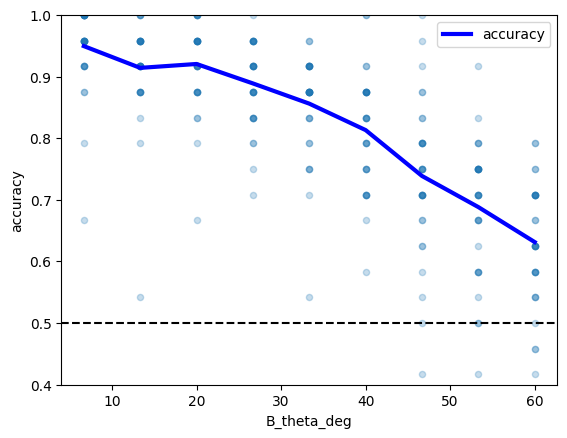

In [29]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
results.plot.scatter(x='B_theta_deg', y='accuracy', ax=ax, alpha=.25)
mean_accuracy_per_B_theta = results.groupby('B_theta_deg')['accuracy'].mean().reset_index()
mean_accuracy_per_B_theta.plot(x='B_theta_deg', y='accuracy', ax=ax, color='b', lw=3)
ax.axhline(.5, color='k', linestyle='--')
ax.set_ylim(.4, 1)
mean_accuracy_per_B_theta

In [30]:
from scipy import stats
# stats.ttest_1samp?

In [31]:
for B_theta in results['B_theta_deg'].unique():
    # print(B_theta, results[results['B_theta_deg'] == B_theta]['accuracy'])
    print(B_theta, stats.ttest_1samp(results[results['B_theta_deg'] == B_theta]['accuracy'], popmean=.5))    

6.666666668598186 TtestResult(statistic=37.05268988926161, pvalue=7.425790737189787e-28, df=32)
13.333333331466793 TtestResult(statistic=28.78827129709939, pvalue=1.8965180365139163e-24, df=32)
20.00000000006498 TtestResult(statistic=34.05324550482325, pvalue=1.0368273338750956e-26, df=32)
26.66666666866316 TtestResult(statistic=33.22456922218856, pvalue=2.2332525249584714e-26, df=32)
33.333333331531776 TtestResult(statistic=24.527535546809432, pvalue=2.569841591202947e-22, df=32)
40.00000000012996 TtestResult(statistic=19.413696515837444, pvalue=2.879113015743776e-19, df=32)
46.66666666872814 TtestResult(statistic=11.111641090550515, pvalue=1.6176343242377348e-12, df=32)
53.333333331596755 TtestResult(statistic=10.216809252491336, pvalue=1.3379114947534476e-11, df=32)
60.00000000019494 TtestResult(statistic=7.942924360294828, pvalue=4.581752985446465e-09, df=32)


## one logistic regression per session

https://laurentperrinet.github.io/sciblog/posts/2020-04-08-fitting-a-psychometric-curve-using-pytorch.html

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

criterion = torch.nn.BCELoss(reduction="mean")

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True, logit0=-2, theta0=0, log_wt=torch.log(0.1*torch.ones(1)), frozen_theta0=False):
        super(LogisticRegressionModel, self).__init__()
        self.theta0 = torch.nn.Parameter(theta0 * torch.ones(1))
        if frozen_theta0: self.theta0.requires_grad = False
        self.logit0 = torch.nn.Parameter(logit0 * torch.ones(1))
        self.logit0 = torch.nn.Parameter(logit0 * torch.ones(1))
        self.log_wt = torch.nn.Parameter(log_wt * torch.ones(1))

    def forward(self, theta):
        p0 = torch.sigmoid(self.logit0)
        out = p0 / 2 + (1 - p0) * torch.sigmoid((theta-self.theta0)/torch.exp(self.log_wt))
        return out


learning_rate = 0.02
etab1, etab2 = 0.02, 0.001
num_epochs = 2 ** 9 + 1
batch_size = 256
amsgrad = False # gives similar results
amsgrad = True  # gives similar results
logit0 = -2
log_wt = 0.1
theta0 = 0
frozen_theta0 = False

def fit_data(
    theta,
    y,
    logit0=-2, log_wt=0.1, theta0=0,
    learning_rate=learning_rate,
    batch_size=batch_size,  
    amsgrad=amsgrad, frozen_theta0=frozen_theta0,
    num_epochs=num_epochs,
    etab1=etab2, etab2=etab2,
    verbose=False
):

    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    logistic_model = LogisticRegressionModel(logit0=logit0, log_wt=log_wt, theta0=theta0, frozen_theta0=frozen_theta0)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=(etab1, etab2), amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for Theta_, labels_ in loader:
            Theta_, labels_ = Theta_.to(device), labels_.to(device)
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.sum(losses)/len(theta):.3e}")

    logistic_model.eval()
    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(Theta)
    loss = criterion(outputs, labels).item() / len(theta)
    return logistic_model, loss

In [33]:
parameters['theta']

0      0.392699
1     -0.249899
2     -0.107100
3      0.321299
4      0.178500
         ...   
211    0.178500
212   -0.392699
213   -0.178500
214   -0.392699
215    0.035700
Name: theta, Length: 216, dtype: float64

In [34]:
np.array(((df_data['swipe_response'] == 'right') + (df_data['keyboard_response'] == 'arrowright')))*1

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1])

for apagrpwbxf, training loss = 1.842e-03 - bias -2.112°, p0 = 0.199, slope = 2.329
for w87npww874, training loss = 1.524e-03 - bias -2.994°, p0 = 0.152, slope = 1.618
for 64dtdq27os, training loss = 2.335e-03 - bias 0.876°, p0 = 0.327, slope = 2.848
for w2oz9j2a3v, training loss = 2.352e-03 - bias 3.446°, p0 = 0.327, slope = 2.949
for wsumnmxd8c, training loss = 1.537e-03 - bias 0.261°, p0 = 0.069, slope = 3.909
for rtumbda4hz, training loss = 2.079e-03 - bias 3.286°, p0 = 0.199, slope = 4.020
for ybaxemnk16, training loss = 1.534e-03 - bias -0.257°, p0 = 0.172, slope = 1.172
for 6l605rv4nn, training loss = 2.625e-03 - bias 1.439°, p0 = 0.415, slope = 3.226
for t7vs2ac7eg, training loss = 1.572e-03 - bias 0.923°, p0 = 0.077, slope = 3.840
for 0ck7pzlpvw, training loss = 1.718e-03 - bias -1.927°, p0 = 0.080, slope = 4.490
for 64jgewoyyw, training loss = 1.849e-03 - bias 2.354°, p0 = 0.107, slope = 4.722
for 39dqyx1uj0, training loss = 1.731e-03 - bias -1.980°, p0 = 0.110, slope = 3.874

[Text(0, 0.0, 'CCW'), Text(0, 1.0, 'CW')]

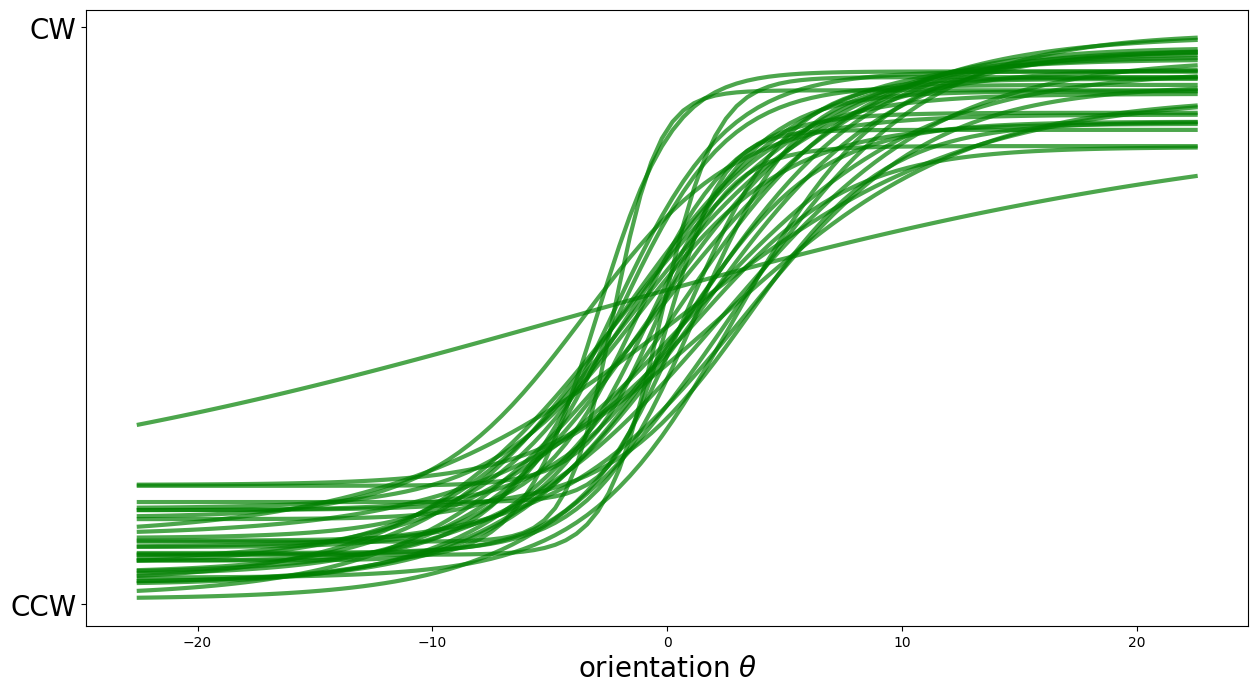

In [ ]:
theta = np.array(parameters['theta'])*180/np.pi
theta_max = theta.max()
x_values = np.linspace(-theta_max, theta_max, 100)[:, None]

fig, ax = plt.subplots(figsize=(15, 8))

for fname in filenames_valid:
    # shorten the name
    session = fname.replace(f'osfstorage-archive/{experiment_name}-', '').replace('-data.json', '')
    # create the dataframe
    df = pd.read_json(fname)
    df_data = df[df['trial_type']=='image-swipe-response'][['trial_index', 'stimulus', 'swipe_response', 'keyboard_response', 'rt', 'response_source']]
    # df_data = df_data.reset_index(drop=True)
    y = np.array(((df_data['swipe_response'] == 'right') + (df_data['keyboard_response'] == 'arrowright')))*1

    logistic_model, loss = fit_data(theta, y, frozen_theta0=False, verbose=False)
    print(f"for {session}, training loss = {loss:.3e} - bias {logistic_model.theta0.item():.3f}°, p0 = {torch.sigmoid(logistic_model.logit0).item():.3f}, slope = {torch.exp(logistic_model.log_wt).item():.3f}")

    y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
    ax.plot(x_values, y_values, "g", alpha=0.7, lw=3, label=session)

ax.set_xlabel(r"orientation $\theta$", fontsize=20)
ax.set_yticks([0.0, 1.0])
ax.set_yticklabels(["CCW", "CW"], fontsize=20)
# plt.legend(fontsize=20, frameon=False, scatterpoints=6);


TypeError: fit_data() got an unexpected keyword argument 'frozen_theta0'

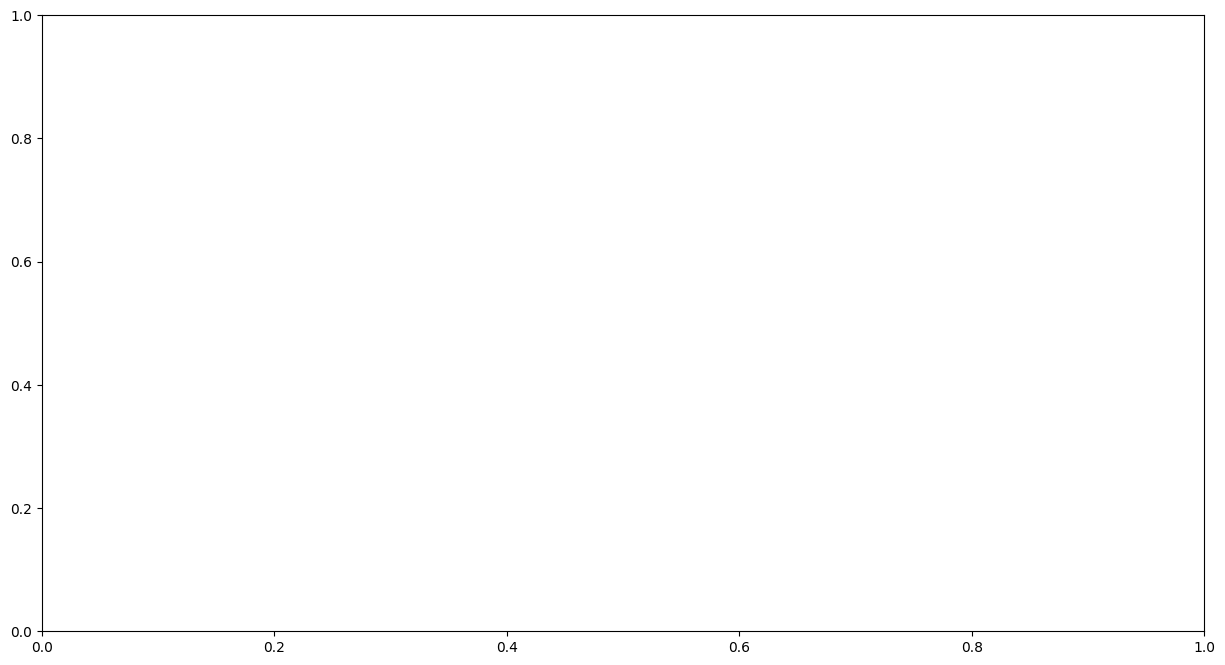

In [39]:
theta = np.array(parameters['theta'])*180/np.pi
theta_max = theta.max()
x_values = np.linspace(-theta_max, theta_max, 100)[:, None]

fig, ax = plt.subplots(figsize=(15, 8))

for fname in filenames_valid:
    # shorten the name
    session = fname.replace(f'osfstorage-archive/{experiment_name}-', '').replace('-data.json', '')
    # create the dataframe
    df = pd.read_json(fname)
    df_data = df[df['trial_type']=='image-swipe-response'][['trial_index', 'stimulus', 'swipe_response', 'keyboard_response', 'rt', 'response_source']]
    # df_data = df_data.reset_index(drop=True)
    y = np.array(((df_data['swipe_response'] == 'right') + (df_data['keyboard_response'] == 'arrowright')))*1

    logistic_model, loss = fit_data(theta, y, frozen_theta0=True, verbose=False)
    print(f"for {session}, training loss = {loss:.3e} - bias {logistic_model.theta0.item():.3f}°, p0 = {torch.sigmoid(logistic_model.logit0).item():.3f}, slope = {torch.exp(logistic_model.log_wt).item():.3f}")

    y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
    ax.plot(x_values, y_values, "g", alpha=0.7, lw=3, label=session)

ax.set_xlabel(r"orientation $\theta$", fontsize=20)
ax.set_yticks([0.0, 1.0])
ax.set_yticklabels(["CCW", "CW"], fontsize=20)
# plt.legend(fontsize=20, frameon=False, scatterpoints=6);


## optimize learning parameters with optuna

In [36]:
logistic_model, loss = fit_data(theta, y, verbose=True)

Iteration: 0 - Loss: 0.00300
Iteration: 16 - Loss: 0.00280
Iteration: 32 - Loss: 0.00268
Iteration: 48 - Loss: 0.00261
Iteration: 64 - Loss: 0.00256
Iteration: 80 - Loss: 0.00253
Iteration: 96 - Loss: 0.00251
Iteration: 112 - Loss: 0.00250
Iteration: 128 - Loss: 0.00249
Iteration: 144 - Loss: 0.00249
Iteration: 160 - Loss: 0.00248
Iteration: 176 - Loss: 0.00248
Iteration: 192 - Loss: 0.00248
Iteration: 208 - Loss: 0.00247
Iteration: 224 - Loss: 0.00247
Iteration: 240 - Loss: 0.00247
Iteration: 256 - Loss: 0.00247
Iteration: 272 - Loss: 0.00247
Iteration: 288 - Loss: 0.00247
Iteration: 304 - Loss: 0.00247
Iteration: 320 - Loss: 0.00247
Iteration: 336 - Loss: 0.00247
Iteration: 352 - Loss: 0.00247
Iteration: 368 - Loss: 0.00247
Iteration: 384 - Loss: 0.00247
Iteration: 400 - Loss: 0.00247
Iteration: 416 - Loss: 0.00247
Iteration: 432 - Loss: 0.00247
Iteration: 448 - Loss: 0.00247
Iteration: 464 - Loss: 0.00247
Iteration: 480 - Loss: 0.00247
Iteration: 496 - Loss: 0.00247
Iteration: 512 -

In [37]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
path_save_optuna = os.path.join('/tmp', 'optuna.sqlite3') # global name
%rm {path_save_optuna}


In [38]:
def objective(trial):
    vars = dict(verbose = False,  num_epochs=num_epochs)
    max_threshold = .999
    vars['batch_size'] = trial.suggest_int('batch_size', 8, 128, log=True, step=1)
    scale = 4
    vars['etab1'] = trial.suggest_float('etab1', etab1/scale, min(etab1*scale, max_threshold), log=True)
    vars['etab2'] = trial.suggest_float('etab2', etab2/scale, min(etab2*scale, max_threshold), log=True)
    vars['learning_rate'] = trial.suggest_float('learning_rate', learning_rate / scale, learning_rate * scale, log=True)
    vars['amsgrad'] = trial.suggest_categorical('amsgrad', [True, False])
    # initialization
    scale = 2
    vars['logit0'] = trial.suggest_float('logit0', logit0 - scale, logit0 + scale, log=False)
    vars['log_wt'] = trial.suggest_float('log_wt', log_wt - scale, log_wt + scale, log=False)
    vars['theta0'] = trial.suggest_float('theta0', theta0 - np.pi/2, theta0 + np.pi/2, log=False)

    loss = 0
    for fname in filenames_valid:
        df = pd.read_json(fname)
        df_data = df[df['trial_type']=='image-swipe-response'][['trial_index', 'stimulus', 'swipe_response', 'keyboard_response', 'rt', 'response_source']]
        y = np.array(((df_data['swipe_response'] == 'right') + (df_data['keyboard_response'] == 'arrowright')))*1
        _, loss_ = fit_data(theta, y, **vars)
        loss += loss_
    return loss


print(50*'=')
sampler = optuna.samplers.TPESampler(multivariate=True)
study = optuna.create_study(direction='minimize', load_if_exists=True, sampler=sampler, storage=f"sqlite:///{path_save_optuna}", study_name='LR')
study.optimize(objective, n_trials=200, n_jobs=1, show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
# print("Best Trial: ", study.best_trial)
print(50*'=')
print(50*'-')
# print("Trials: ", study.trials)


/usr/local/lib/python3.9/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'batch_size': 12, 'etab1': 0.014183698739014244, 'etab2': 0.0003672872589649993, 'learning_rate': 0.01954920964768988, 'amsgrad': True, 'logit0': -2.027273868893802, 'log_wt': 1.1493629832487078, 'theta0': -1.483539842076246}
Best value:  0.002468590107229021
--------------------------------------------------
